In [ ]:
from google.colab import files
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [ ]:
uploaded = files.upload()

Saving 16068.jpg to 16068.jpg
Saving 20069.jpg to 20069.jpg
Saving 41096.jpg to 41096.jpg
Saving 43051.jpg to 43051.jpg
Saving 49024.jpg to 49024.jpg
Saving 77062.jpg to 77062.jpg


<class 'numpy.ndarray'>
(481, 321, 3)


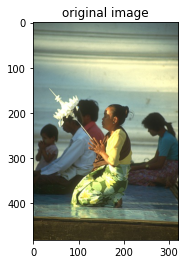

In [ ]:
Img = mpimg.imread("20069.jpg")
print(type(Img))
print(Img.shape)
plt.title('original image')
plt.imshow(Img)

(481, 321)


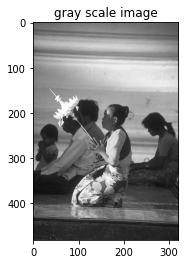

In [ ]:
[rows,cols,pages] = np.shape(Img)
# Split image into seperate r g b channels
r=Img[:,:,0]
g=Img[:,:,1]
b=Img[:,:,2]

# Grey image
Gray_Img=r/3+g/3+b/3
plt.title('gray scale image')
plt.imshow(Gray_Img, cmap ='gray')
print(Gray_Img.shape)

In [ ]:
# generate the Gaussian 5x5 kernel
# sigma = 1.4
def gaussian_kernel(size, sigma=1.4):
    
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    N = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * N
    
    return g

[[0.04875119 0.06291796 0.04875119]
 [0.06291796 0.0812015  0.06291796]
 [0.04875119 0.06291796 0.04875119]]


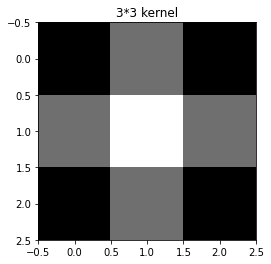

In [ ]:
size = 3
G_kernel = gaussian_kernel(size = 3, sigma=1.4)
print(G_kernel)
plt.title('3*3 kernel')
plt.imshow(G_kernel, cmap = 'gray')

In [ ]:
def convolution2d(image, kernel, Pd=0, S=1):
    kernel = np.flipud(np.fliplr(kernel))
    Xk = kernel.shape[0]
    Yk = kernel.shape[1]
    Xi = image.shape[0]
    Yi = image.shape[1]
    
     # Shape of Output Convolution
    Xo = int(((Xi - Xk + 2 * Pd) / S) + 1)
    Yo = int(((Yi - Yk + 2 * Pd) / S) + 1)
    out = np.zeros((Xo, Yo))
    
    if Pd != 0:
        Ip = np.zeros((image.shape[0] + Pd*2, image.shape[1] + Pd*2))   # Ip = padded image
        Ip[int(Pd):int(-1 * Pd), int(Pd):int(-1 * Pd)] = image
        print(Ip)
    else:
        Ip = image
        
    for y in range(Yi):
        # Exit Convolution
        if y > Yi - Yk:
            break

        if y % S == 0:
            for x in range(Xi):
                # Go to next row once kernel is out of bounds
                if x > Xi - Xk:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % S == 0:
                        out[x, y] = (kernel * Ip[x: x + Xk, y: y + Yk]).sum()
                except:
                    break
                    
    return out    

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.         51.         ... 66.          0.
   0.        ]
 ...
 [ 0.          0.         10.66666667 ...  9.33333333  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


(483, 323)

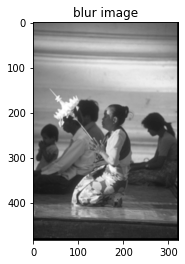

In [ ]:
G_kernel = gaussian_kernel(size = 3, sigma=1.4)
Blur_Img = convolution2d(Gray_Img, G_kernel, Pd=2, S=1)
plt.title('blur image')
plt.imshow(Blur_Img, cmap ='gray')
Blur_Img.shape

In [ ]:
from scipy import ndimage

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    print(G.shape)
    plt.title('Sobel image')
    plt.imshow(G,cmap = 'gray')
 
    return (G, theta)

(483, 323)


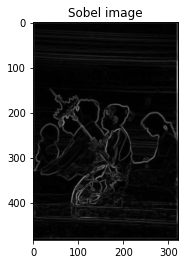

In [ ]:
Sobel, theta = sobel_filters(Blur_Img)

In [ ]:
Img = Sobel
D = theta
def non_max_suppression(Img, D):
    M, N = Img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = Img[i, j+1]
                    r = Img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = Img[i+1, j-1]
                    r = Img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = Img[i+1, j]
                    r = Img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = Img[i-1, j-1]
                    r = Img[i+1, j+1]

                if (Img[i,j] >= q) and (Img[i,j] >= r):
                    Z[i,j] = Img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

(483, 323)

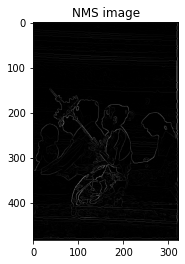

In [ ]:
NMS_Img = non_max_suppression(Sobel, theta)
plt.title('NMS image')
plt.imshow(NMS_Img,cmap='gray')
NMS_Img.shape

In [ ]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    print('weak pixel is: ',weak)
    return (res, weak, strong)

weak pixel is:  25


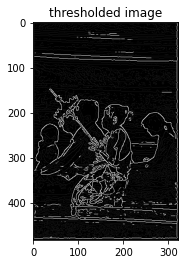

In [ ]:
res,weak,strong = threshold(NMS_Img, lowThresholdRatio=0.05, highThresholdRatio=0.09)
plt.title('thresholded image')
plt.imshow(res,cmap='gray')

In [ ]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        
                        img[i, j] = strong
                        
                    else:
                        img[i, j] = 0
                        
                except IndexError as e:
                    pass
    return img

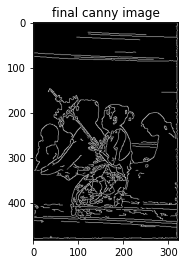

In [ ]:
Canny = hysteresis(res, weak, strong=255)
plt.title('final canny image')
plt.imshow(Canny,cmap = 'gray')